<a href="https://colab.research.google.com/github/venkata72/Real-Time-AI-Sales-Call-Assistant/blob/main/lead_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from scipy.stats import linregress, uniform
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix

In [ ]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [ ]:
df = pd.read_csv('/content/Lead Scoring.csv.zip')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [ ]:
df.shape

(9240, 37)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [ ]:
binary_cats = ['Do Not Email','Do Not Call','Search','Magazine','Newspaper Article',
               'X Education Forums','Newspaper','Digital Advertisement','Through Recommendations',
               'Receive More Updates About Our Courses', 'Update me on Supply Chain Content','Get updates on DM Content',
               'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']

null_values = df[binary_cats].isnull().sum()
total = df[binary_cats].count()
yes_no = df[binary_cats].applymap(lambda x: 1 if x == 'Yes' or x == 'No' else 0).sum()
df_binary_cats = pd.DataFrame({'total': total,
                               'null_%': null_values/total*100,
                               'yes/no_%': yes_no/total*100})
df_binary_cats

<ipython-input-6-cfbaffb818fb>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  yes_no = df[binary_cats].applymap(lambda x: 1 if x == 'Yes' or x == 'No' else 0).sum()


,total,null_%,yes/no_%
Do Not Email,9240,0.0,100.0
Do Not Call,9240,0.0,100.0
Search,9240,0.0,100.0
Magazine,9240,0.0,100.0
Newspaper Article,9240,0.0,100.0
X Education Forums,9240,0.0,100.0
Newspaper,9240,0.0,100.0
Digital Advertisement,9240,0.0,100.0
Through Recommendations,9240,0.0,100.0
Receive More Updates About Our Courses,9240,0.0,100.0


In [ ]:
train, test = train_test_split(df, test_size=.2, random_state=12, stratify=df['Converted'])
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (7392, 37)
test shape: (1848, 37)


In [ ]:
print(f'In the train set are {train.duplicated().sum()} duplicates')

In the train set are 0 duplicates


In [ ]:
train['Asymmetrique Profile Index'].value_counts(dropna=False)

,count
Asymmetrique Profile Index,
NaN,3362
02.Medium,2243
01.High,1762
03.Low,25


In [ ]:
train['Asymmetrique Activity Index'].value_counts(dropna=False)

,count
Asymmetrique Activity Index,
NaN,3362
02.Medium,3080
01.High,648
03.Low,302


In [ ]:
def data_cleaning(df):
  """Do some of the data cleaning procedures that we
  specified at the begining of the notebook"""
  # drop columns id columns
  df = df.drop(['Prospect ID','Lead Number'], axis=1)

  # asymmetrique index columns transformation
  df['Asymmetrique Activity Index'] = df['Asymmetrique Activity Index'].str.split('.', expand=True)[0]\
                                                                        .str.replace('0','').str.replace('1','4')\
                                                                        .str.replace('3','1').str.replace('4','3')\
                                                                        .astype(np.float64
                                                                               )
  df['Asymmetrique Profile Index'] = df['Asymmetrique Profile Index'].str.split('.', expand=True)[0]\
                                                                        .str.replace('0','').str.replace('1','4')\
                                                                        .str.replace('3','1').str.replace('4','3')\
                                                                        .astype(np.float64
                                                                               )
  # binary encoding
  df[binary_cats] = df[binary_cats].applymap(lambda x: 0 if x == 'No' else 1)

  # rename columns for practicity
  df.columns = df.columns.str.replace(' ','_').str.lower()
  return df

# Convert custom function into transformer
initial_clean = FunctionTransformer(data_cleaning)

train_clean = initial_clean.fit_transform(train);

<ipython-input-11-6b3985b0ec73>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[binary_cats] = df[binary_cats].applymap(lambda x: 0 if x == 'No' else 1)


In [ ]:
train_clean.lead_origin.value_counts(dropna=False);

In [ ]:
train_clean.lead_source.value_counts(dropna=False);

In [ ]:
train_clean.last_activity.value_counts(dropna=False);

In [ ]:
train_clean.country.value_counts(dropna=False);
train_clean.specialization.value_counts(dropna=False);
train_clean.how_did_you_hear_about_x_education.value_counts(dropna=False);
train_clean.what_is_your_current_occupation.value_counts(dropna=False);
train_clean.what_matters_most_to_you_in_choosing_a_course.value_counts(dropna=False);
train_clean.tags.value_counts(dropna=False);
train_clean.lead_quality.value_counts(dropna=False);
train_clean.lead_profile.value_counts(dropna=False);
train_clean.city.value_counts(dropna=False);
train_clean.last_notable_activity.value_counts(dropna=False);

In [ ]:
def initial_feature_engineering(df):
  """Do some feature engineering"""
  # lead_source
  df['lead_source'] = df['lead_source'].str.replace('|'.join(['google','Pay per Click Ads']),'Google')
  df['lead_source'] = df['lead_source'].apply(lambda x: "Referral Sites" if 'blog' in str(x) else x)
  df['lead_source'] = df['lead_source'].str.replace('Live Chat','Olark Chat')
  df['lead_source'] = df['lead_source'].str.replace('bing','Organic Search')
  df['lead_source'] = df[df['lead_source'] != 'Other'].lead_source.apply(lambda x: "Other" if str(x) not in train_clean.lead_source.value_counts()[:8].index else x)
  # last_activity and last_notable_activity
  activity = ['last_activity','last_notable_activity']
  df[activity] = df[activity].apply(lambda x: x.str.replace('|'.join(['Email Received','SMS Sent']),'SMS/Email Sent'))
  df[activity] = df[activity].apply(lambda x: x.str.replace('|'.join(['Email Marked Spam','Email Bounced','Unsubscribed']),'Not interested in email'))
  df[activity] = df[activity].apply(lambda x: x.str.replace('Resubscribed to emails','Email Opened'))
  df[activity] = df[activity].apply(lambda x: x.str.replace('|'.join(['Visited Booth in Tradeshow','View in browser link Clicked']),'Page Visited on Website'))
  # country
  df['country'] = df['country'].apply(lambda x: np.nan if x in ['Unknown','unknown','Asia/Pacific Region'] else x)
  # specialization
  df['specialization'] = df['specialization'].str.replace('|'.join(['E-COMMERCE','E-Business']),'E-commerce')
  df['specialization'] = df['specialization'].str.replace('Banking, Investment And Insurance','Finance Management')
  df['specialization'] = df['specialization'].str.replace('Media and Advertising','Marketing Management')
  df['specialization'] = df['specialization'].str.replace('Select','Not Provided')
  # how_did_you_hear
  df['how_did_you_hear_about_x_education'] = df['how_did_you_hear_about_x_education'].str.replace('Select','Not Provided')
  df['how_did_you_hear_about_x_education'] = df['how_did_you_hear_about_x_education'].str.replace('|'.join(['SMS','Email']),'SMS/Email')
  # importance_in_course
  df['what_matters_most_to_you_in_choosing_a_course'] = df['what_matters_most_to_you_in_choosing_a_course'].str.replace('|'.join(['Flexibility & Convenience','Other']),"Better Career Prospects")
  # lead_profile
  df['lead_profile'] = df['lead_profile'].str.replace('Select','Not Assigned')
  # city
  df['city'] = df['city'].str.replace('Select','Not Provided')

  return df

initial_feature_engineering = FunctionTransformer(initial_feature_engineering)
train_clean = initial_feature_engineering.fit_transform(train_clean);

In [ ]:
train_ = train_clean.copy()

# Set style for better visualizations
train_eda = train.copy()
sns.set_style('dark')
sns.set(rc={'axes.grid':False})
sns.set_palette('viridis')

In [ ]:
null_ = pd.DataFrame()
null_['proportion'] = np.round(train_clean.isnull().sum()/len(train_clean),4) * 100
null_['amount'] = train_clean.isnull().sum()

# Show only those columns with at least 1 missing value
null_.sort_values(by='proportion', ascending=False)[null_.amount > 0]

<ipython-input-18-acbc4cad5bea>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  null_.sort_values(by='proportion', ascending=False)[null_.amount > 0]


,proportion,amount
lead_quality,51.35,3796
asymmetrique_activity_index,45.48,3362
asymmetrique_profile_score,45.48,3362
asymmetrique_profile_index,45.48,3362
asymmetrique_activity_score,45.48,3362
tags,36.35,2687
lead_profile,29.40,2173
what_matters_most_to_you_in_choosing_a_course,29.40,2173
what_is_your_current_occupation,29.21,2159
country,26.50,1959


In [ ]:
def barplot_catcols(column,width,heigh):
  """Plot conversion rate"""
  fig, ax  = plt.subplots(figsize=(width,heigh))
  ax = sns.barplot(data=train_.fillna('NaN'), x='converted', y=column,
            order=order(train_.fillna('NaN'),column),
            orient='h', palette='viridis',
            seed=2)
  plt.title(f'Conversion Rate by {column.replace("_"," ").title()}', loc='left', size=18)
  return ax

def order(df,x,y=None):
    if y is not None:
        return df.groupby(x)[y].mean().sort_values(ascending=False).index
    else:
        return df.groupby(x)['converted'].mean().sort_values(ascending=False).index

<ipython-input-20-675d1eb7fed0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=train_.fillna('NaN'), x='converted', y='amount_missing',


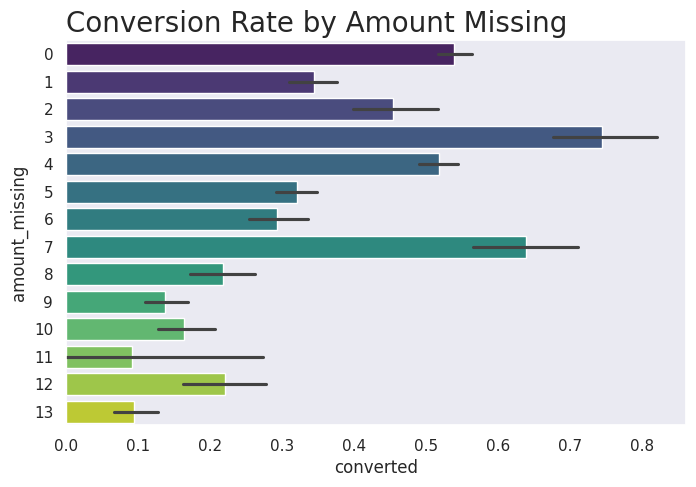

In [ ]:
# Number of missing values in each row
train_['amount_missing'] = train_.isnull().sum(1)

# Plot the relation between amount missing and conversion rate
fig, ax  = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=train_.fillna('NaN'), x='converted', y='amount_missing',
            orient='h', palette='viridis',
            seed=2)
plt.title(f'Conversion Rate by Amount Missing', loc='left', size=20)
plt.show()

<ipython-input-21-7c515b63e4d7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=train_, x='amount_missing', y='converted',


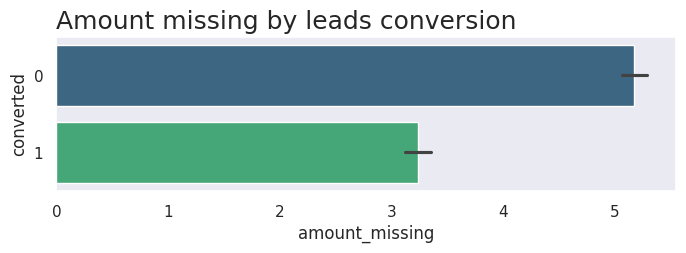

In [ ]:
fig, ax  = plt.subplots(figsize=(8,2))
ax = sns.barplot(data=train_, x='amount_missing', y='converted',
            orient='h', palette=sns.color_palette('viridis',2),
            seed=2)
plt.title(f'Amount missing by leads conversion', loc='left', size=18)
plt.show()

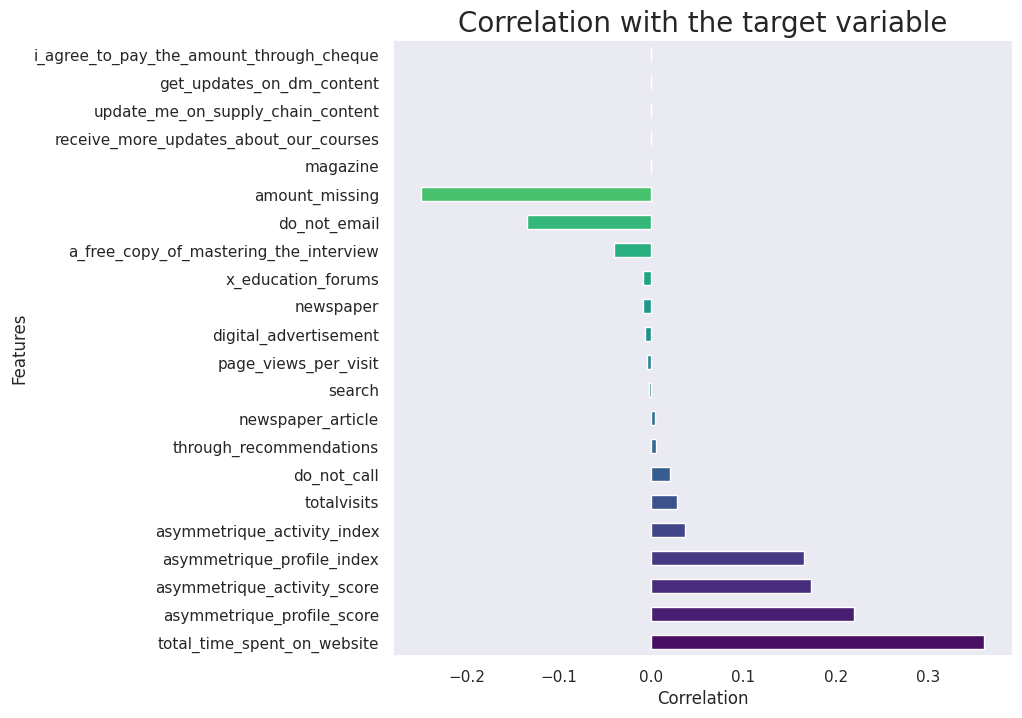

In [ ]:
correlations = train_.select_dtypes('number').corr()['converted'].sort_values(ascending=False)

plt.figure(figsize=(8, 8))
correlations[1:].plot(kind='barh',
                 color=sns.color_palette('viridis', len(correlations)))

plt.title('Correlation with the target variable', fontsize=20)
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

In [ ]:
print(f'Duplicate rows from original dataset: {train.duplicated().sum()}')
print(f'Duplicate rows after feature engineer: {train_clean.duplicated().sum()}')

Duplicate rows from original dataset: 0
Duplicate rows after feature engineer: 984


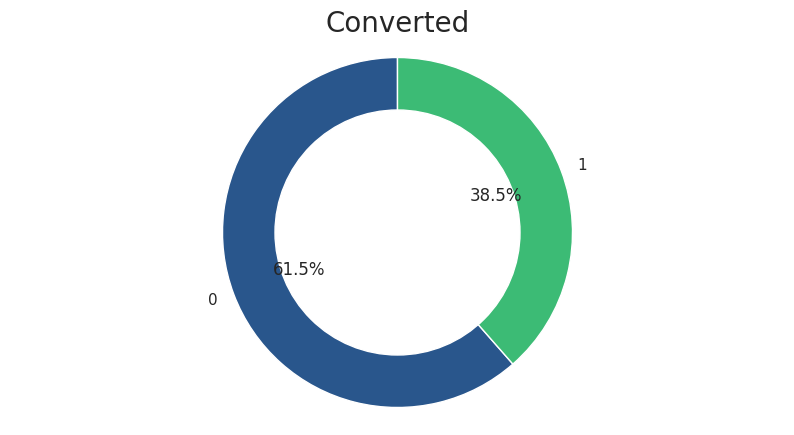

In [ ]:
count = train_['converted'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
ax.pie(count, labels=count.index, autopct='%1.1f%%', startangle=90, colors=['#29568CFF', '#3CBB75FF'])
ax.set_title('Converted', size=20)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

In [ ]:
train_.loc[:,'asymmetrique_activity_index':'asymmetrique_profile_score'].corr().style.background_gradient(cmap='vlag_r')

,asymmetrique_activity_index,asymmetrique_profile_index,asymmetrique_activity_score,asymmetrique_profile_score
asymmetrique_activity_index,1.000000,-0.145399,0.855985,-0.122669
asymmetrique_profile_index,-0.145399,1.000000,-0.145366,0.883177
asymmetrique_activity_score,0.855985,-0.145366,1.000000,-0.114636
asymmetrique_profile_score,-0.122669,0.883177,-0.114636,1.000000


<ipython-input-26-b7c39306065e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_.fillna('NaN'), x='lead_profile', y='converted',
<ipython-input-26-b7c39306065e>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
<ipython-input-26-b7c39306065e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_.fillna('NaN'), x='asymmetrique_profile_score', y='converted',
<ipython-input-26-b7c39306065e>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_x

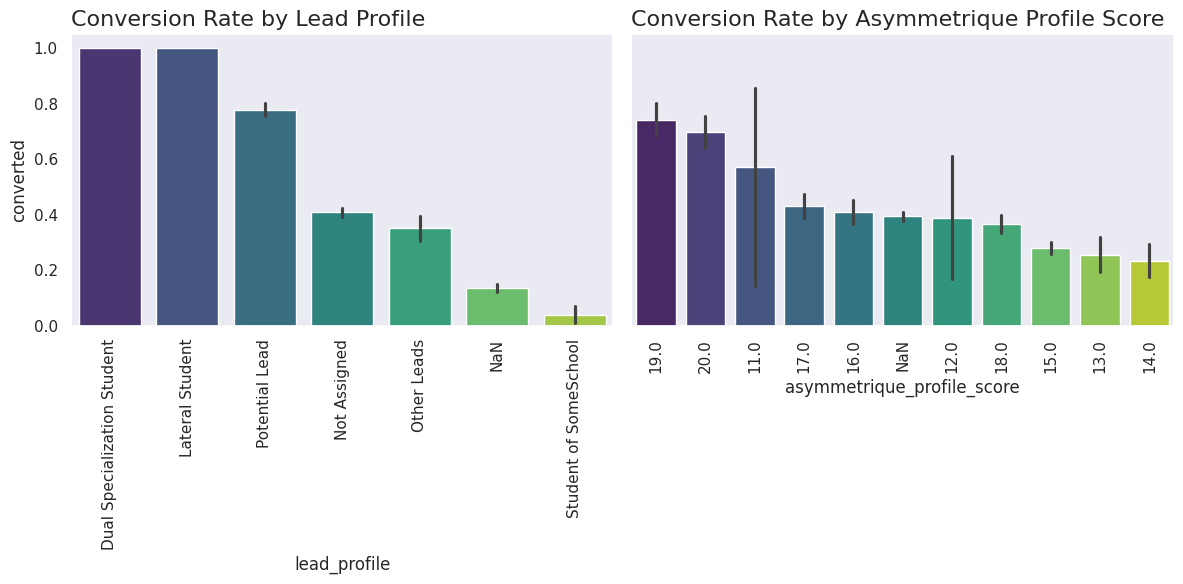

In [ ]:
fig, ax  = plt.subplots(1,2, figsize=(12,6), sharey=True)

sns.barplot(data=train_.fillna('NaN'), x='lead_profile', y='converted',
            palette='viridis', order=order(train_.fillna('NaN'),'lead_profile'),
            seed=2, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title(f'Conversion Rate by Lead Profile', loc='left', size=16)

sns.barplot(data=train_.fillna('NaN'), x='asymmetrique_profile_score', y='converted',
                  palette='viridis', order=order(train_.fillna('NaN'),'asymmetrique_profile_score'),
                    seed=2, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title(f'Conversion Rate by Asymmetrique Profile Score', loc='left', size=16)

plt.tight_layout()
plt.show()

In [ ]:
activity_columns = ['totalvisits','total_time_spent_on_website','page_views_per_visit',
                    'asymmetrique_profile_score','asymmetrique_activity_score']

train_[activity_columns].corr().style.background_gradient(cmap='vlag_r')

,totalvisits,total_time_spent_on_website,page_views_per_visit,asymmetrique_profile_score,asymmetrique_activity_score
totalvisits,1.000000,0.261952,0.598883,0.129016,-0.061397
total_time_spent_on_website,0.261952,1.000000,0.323684,0.167992,-0.066008
page_views_per_visit,0.598883,0.323684,1.000000,0.165945,-0.171264
asymmetrique_profile_score,0.129016,0.167992,0.165945,1.000000,-0.114636
asymmetrique_activity_score,-0.061397,-0.066008,-0.171264,-0.114636,1.000000


<ipython-input-28-9c501107a754>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_.fillna('NaN'), x='last_activity', y='converted',
<ipython-input-28-9c501107a754>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
<ipython-input-28-9c501107a754>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_.fillna('NaN'), x='last_notable_activity', y='converted',
<ipython-input-28-9c501107a754>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xtic

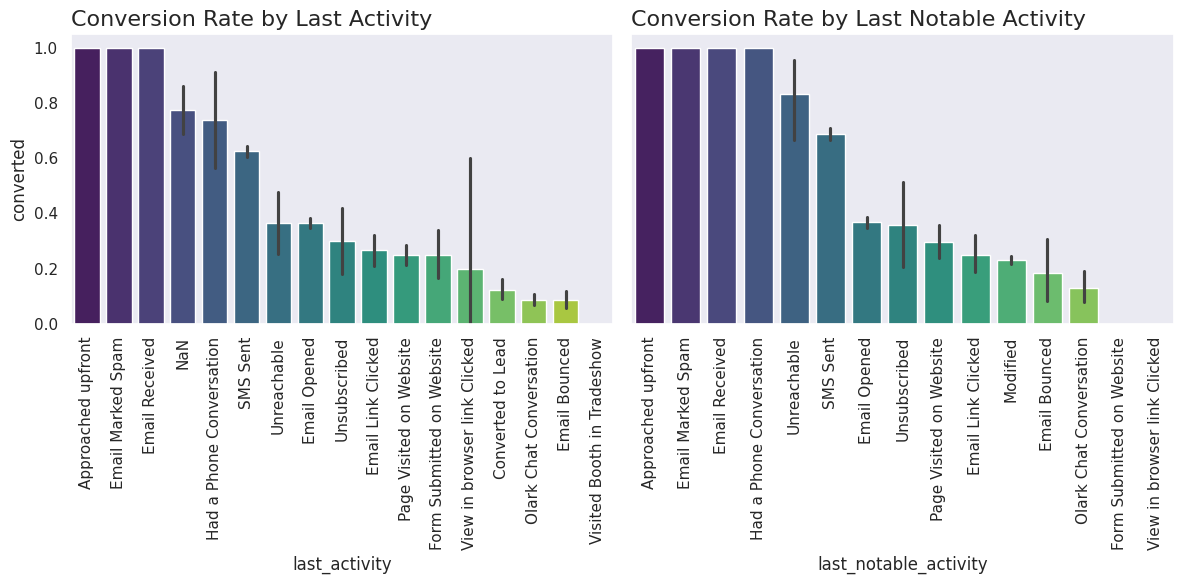

In [ ]:
fig, ax  = plt.subplots(1,2, figsize=(12,6), sharey=True)

sns.barplot(data=train_.fillna('NaN'), x='last_activity', y='converted',
            order=order(train_.fillna('NaN'),'last_activity'),
            palette='viridis',
            seed=2, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title(f'Conversion Rate by Last Activity', loc='left', size=16)

sns.barplot(data=train_.fillna('NaN'), x='last_notable_activity', y='converted',
                  order=order(train_.fillna('NaN'),'last_notable_activity'),
                  palette='viridis', seed=2)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title(f'Conversion Rate by Last Notable Activity', loc='left', size=16)

plt.tight_layout()
plt.show()

<ipython-input-19-1a3a84beccea>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=train_.fillna('NaN'), x='converted', y=column,


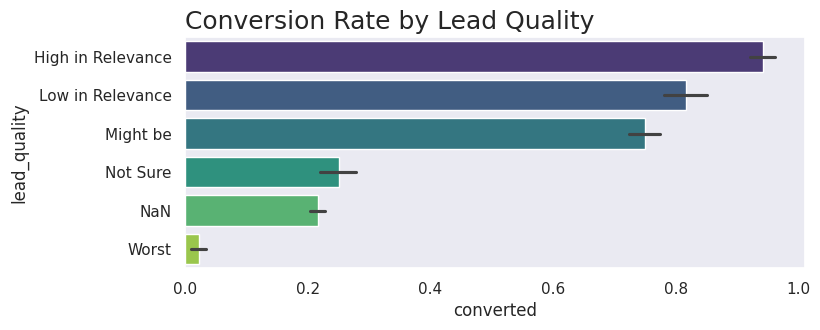

In [ ]:
barplot_catcols('lead_quality',8,3)
plt.show()

<ipython-input-30-d807eee89c95>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_.fillna('NaN'), x='tags', y='converted',


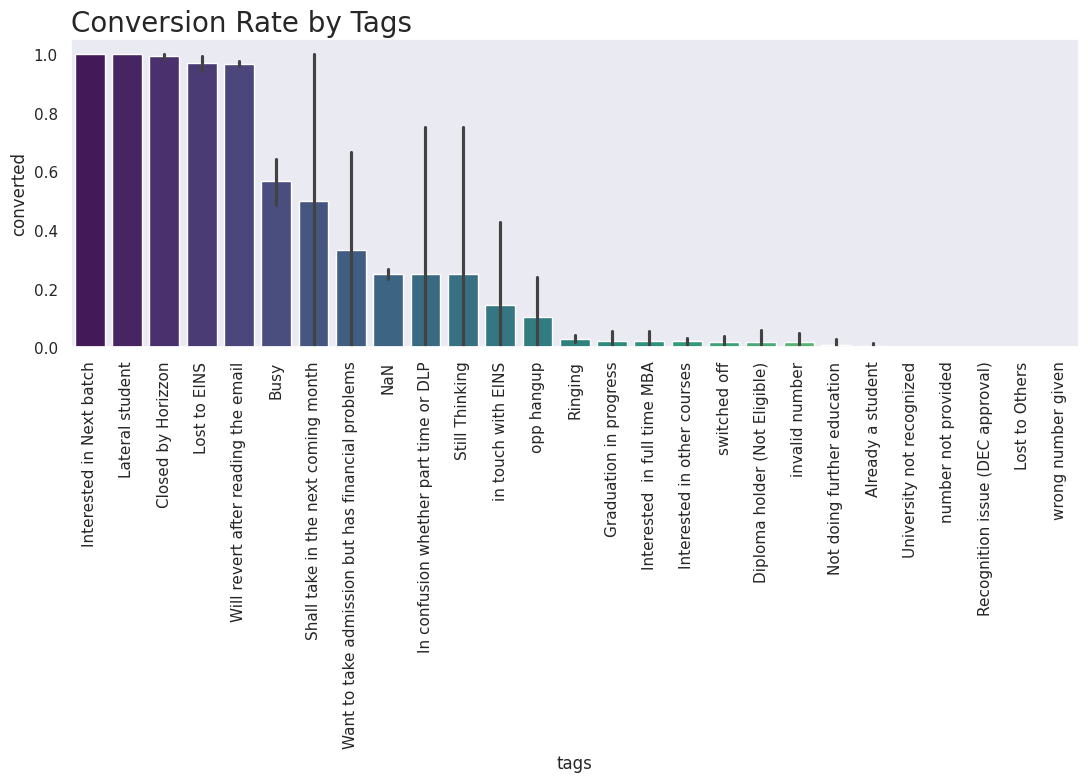

In [ ]:
fig, ax  = plt.subplots(figsize=(13,4))

sns.barplot(data=train_.fillna('NaN'), x='tags', y='converted',
            order=order(train_.fillna('NaN'),'tags'),
            palette='viridis',
            seed=2)
plt.xticks(rotation=90)
plt.title(f'Conversion Rate by Tags', loc='left', size=20)
plt.show()

<ipython-input-31-43d3308e4512>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_.fillna('NaN'), x='specialization', y='converted',
<ipython-input-31-43d3308e4512>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
<ipython-input-31-43d3308e4512>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_.fillna('NaN'), x='what_is_your_current_occupation', y='converted',
<ipython-input-31-43d3308e4512>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[

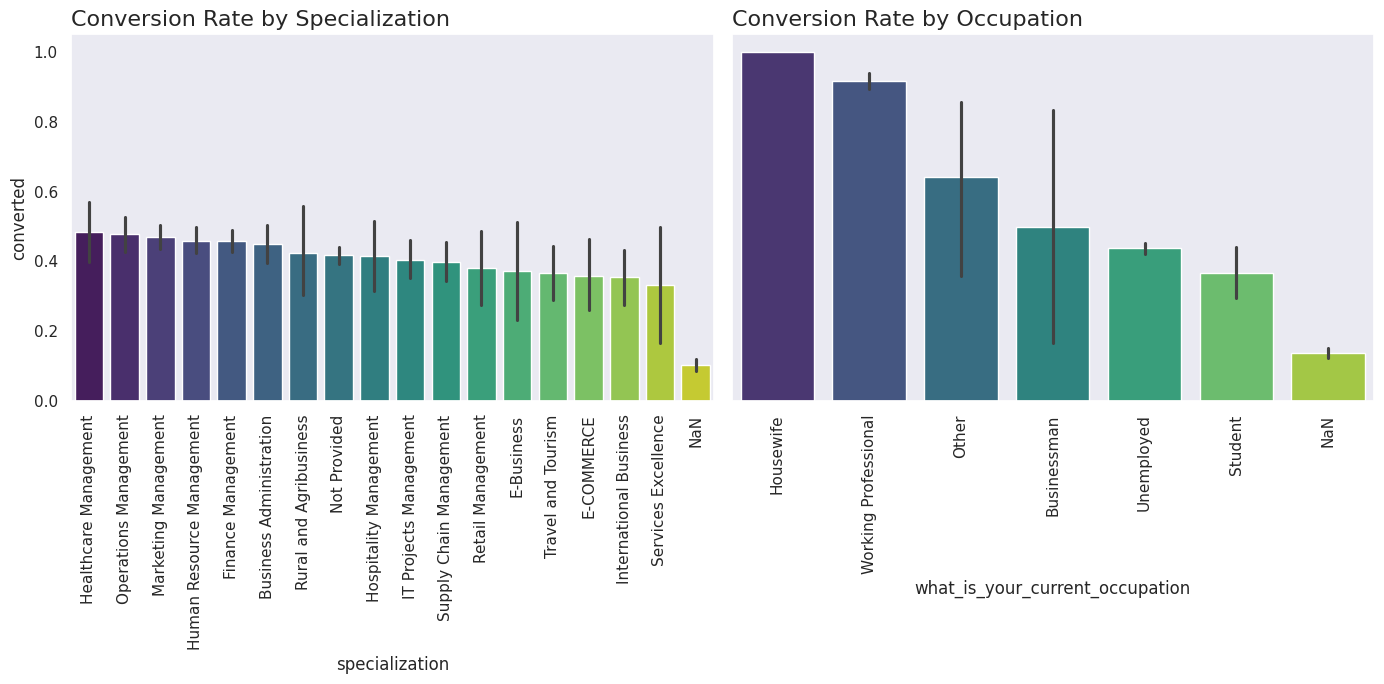

In [ ]:
fig, ax  = plt.subplots(1,2, figsize=(14,7), sharey=True)

sns.barplot(data=train_.fillna('NaN'), x='specialization', y='converted',
            order=order(train_.fillna('NaN'),'specialization'),
            palette='viridis',
            seed=2, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title(f'Conversion Rate by Specialization', loc='left', size=16)

sns.barplot(data=train_.fillna('NaN'), x='what_is_your_current_occupation', y='converted',
                  order=order(train_.fillna('NaN'),'what_is_your_current_occupation'),
                  palette='viridis', seed=2)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title(f'Conversion Rate by Occupation', loc='left', size=16)

plt.tight_layout()
plt.show()

In [ ]:
train_[['what_is_your_current_occupation','specialization']].isnull().sum(1).value_counts()

,count
0,5220
2,1141
1,1031


In [ ]:
conversion_country = train_.groupby('country')['converted'].mean()
country_count = train_['country'].value_counts().sort_index()

fig = go.Figure(data=go.Choropleth(
    locations=conversion_country.index,
    locationmode='country names',
    z=conversion_country.values,
    text=country_count.values,
    colorscale='deep',
    colorbar_title='Conversion Rate',
    hovertemplate='%{location}<br>Conversion: %{z:.2f}<br>Count: %{text}',
))

fig.update_geos(projection_type="mercator")

fig.update_layout(
    title='Conversion Rate by Country',
    geo=dict(showcoastlines=True),
    font=dict(size=16),
)

fig.show()

In [ ]:
train_['country'].value_counts().sort_index()

,count
country,
Australia,9
Bahrain,6
Bangladesh,2
Belgium,2
Canada,3
China,2
Denmark,1
France,4
Germany,4


<ipython-input-19-1a3a84beccea>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




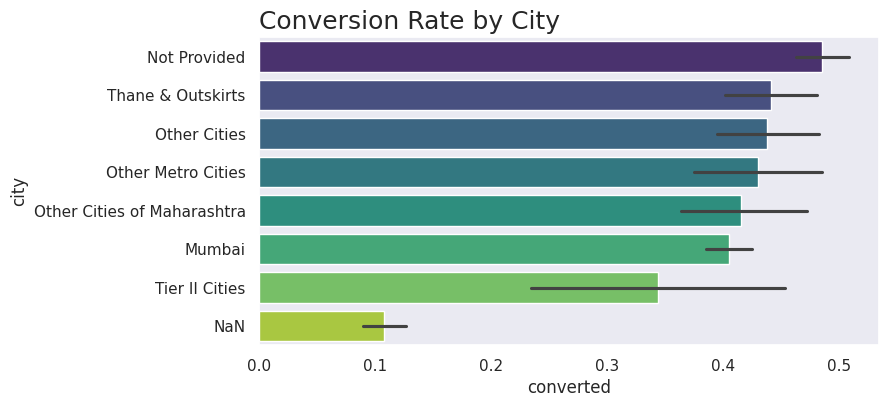

In [ ]:
barplot_catcols('city',8,4)
plt.show()

In [ ]:
print("Cities where country isn't India:")
train_[train_['country'] != 'India'].city.value_counts(dropna=False)

Cities where country isn't India:


,count
city,
Not Provided,992
NaN,693
Mumbai,244
Other Cities,98
Thane & Outskirts,83
Other Cities of Maharashtra,49
Other Metro Cities,27
Tier II Cities,5


In [ ]:
print("Cities where country isn't India:")
train_[train_['country'] != 'India'].city.value_counts(dropna=False)

Cities where country isn't India:


,count
city,
Not Provided,992
NaN,693
Mumbai,244
Other Cities,98
Thane & Outskirts,83
Other Cities of Maharashtra,49
Other Metro Cities,27
Tier II Cities,5


In [ ]:
print('Countries where City es equal to an Indian city:')
indian_cities = ['Mumbai','Thane & Outskirts','Other Cities of Maharashtra','Tier II Cities']
train_[train_.city.isin(indian_cities)].country.value_counts(dropna=False)

Countries where City es equal to an Indian city:


,count
country,
India,3220
NaN,270
United States,32
United Arab Emirates,19
Singapore,11
United Kingdom,9
Saudi Arabia,8
Australia,6
Qatar,5


<ipython-input-39-a139e3f42f2d>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-39-a139e3f42f2d>:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-39-a139e3f42f2d>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-39-a139e3f42f2d>:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



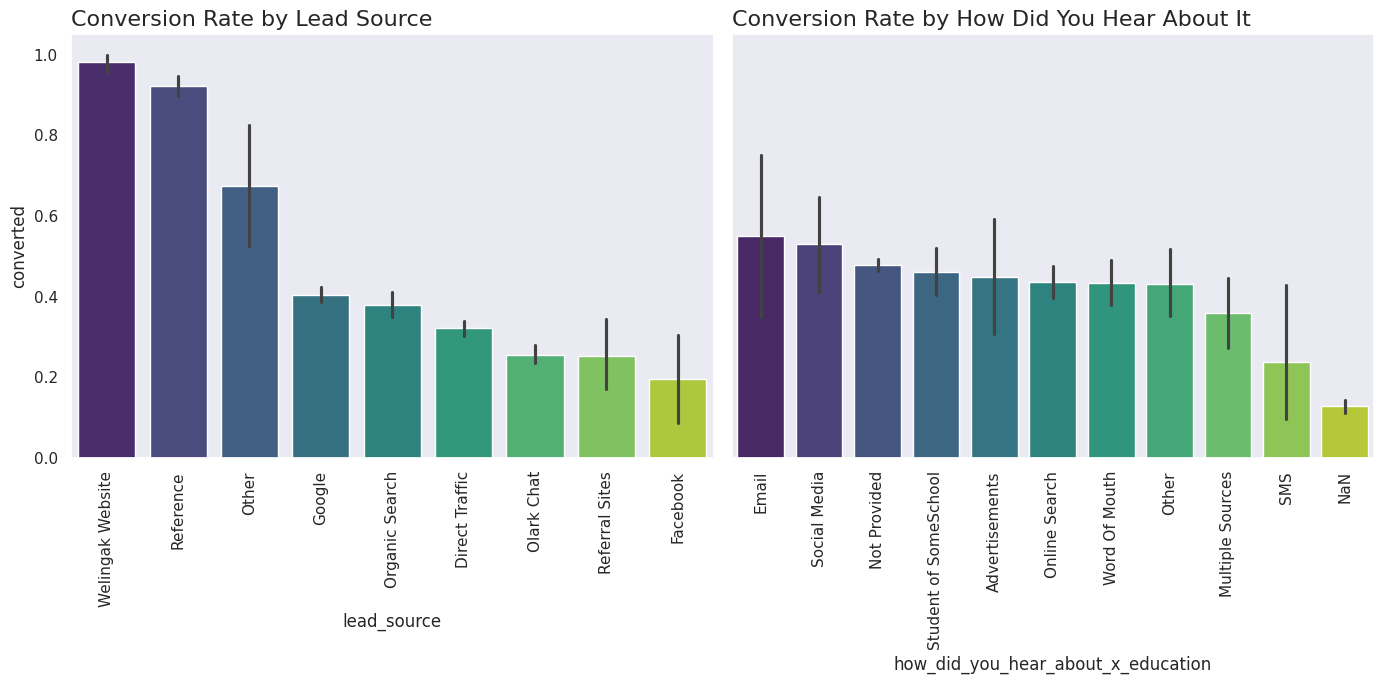

In [ ]:
fig, ax  = plt.subplots(1,2, figsize=(14,7), sharey=True)

sns.barplot(data=train_.fillna('NaN'), x='lead_source', y='converted',
            order=order(train_.fillna('NaN'),'lead_source'),
            palette='viridis',
            seed=2, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title(f'Conversion Rate by Lead Source', loc='left', size=16)

sns.barplot(data=train_.fillna('NaN'), x='how_did_you_hear_about_x_education', y='converted',
                  order=order(train_.fillna('NaN'),'how_did_you_hear_about_x_education'),
                  palette='viridis', seed=2)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title(f'Conversion Rate by How Did You Hear About It', loc='left', size=16)

plt.tight_layout()
plt.show()

In [ ]:
train_.select_dtypes(include=['number']).nunique().sort_values()

,0
i_agree_to_pay_the_amount_through_cheque,1
get_updates_on_dm_content,1
update_me_on_supply_chain_content,1
receive_more_updates_about_our_courses,1
magazine,1
do_not_email,2
through_recommendations,2
a_free_copy_of_mastering_the_interview,2
newspaper,2
digital_advertisement,2


<ipython-input-41-09298a34761e>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-41-09298a34761e>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-41-09298a34761e>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




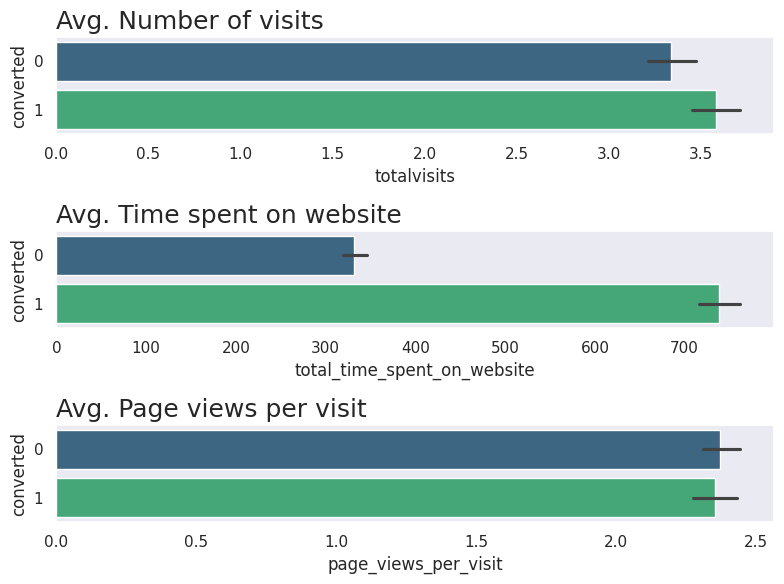

In [ ]:
fig, ax  = plt.subplots(3, figsize=(8,6))
sns.barplot(data=train_, x='totalvisits', y='converted',
            orient='h', palette='viridis',
            seed=2, ax=ax[0])
ax[0].set_title(f'Avg. Number of visits', loc='left', size=18)

sns.barplot(data=train_, x='total_time_spent_on_website', y='converted',
            orient='h', palette='viridis',
            seed=2, ax=ax[1])
ax[1].set_title(f'Avg. Time spent on website', loc='left', size=18)

sns.barplot(data=train_, x='page_views_per_visit', y='converted',
            orient='h', palette='viridis',
            seed=2, ax=ax[2])
ax[2].set_title(f'Avg. Page views per visit', loc='left', size=18)

plt.tight_layout()
plt.show()

<ipython-input-42-fa4e37c5d263>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-42-fa4e37c5d263>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-42-fa4e37c5d263>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




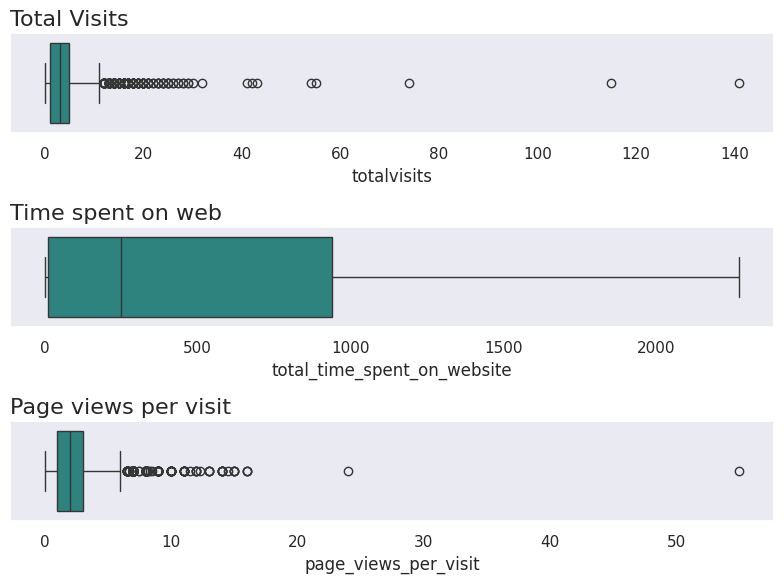

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,6))
sns.boxplot(data=train_, x='totalvisits',
              ax=ax[0], palette='viridis')
ax[0].set_title('Total Visits', loc='left', size=16)

sns.boxplot(data=train_, x='total_time_spent_on_website',
              ax=ax[1], palette='viridis')
ax[1].set_title('Time spent on web', loc='left', size=16)

sns.boxplot(data=train_, x='page_views_per_visit',
              ax=ax[2], palette='viridis')
ax[2].set_title('Page views per visit', loc='left', size=16)

plt.tight_layout()
plt.show()

In [ ]:
def eda_feature_engineering(df):
  # tags column
  df['tags'] = df['tags'].str.replace('|'.join(['invalid number','wrong number given','number not provided']),'Not interest in calls')
  df['tags'] = df['tags'].str.replace('|'.join(["In confusion whether part time or DLP", "Interested in Next batch", "Shall take in the next coming month", "Still Thinking"]), "Shows certain interest")
  df['tags'] = df['tags'].str.replace("University not recognized","Not elegible")
  df['tags'] = df[df['tags'].notnull()].tags.apply(lambda x: 'Not elegible' if 'holder' in x else x)
  df['tags'] = df['tags'].str.replace('|'.join(["Interested in other courses", "Interested  in full time MBA", "Not doing further education"]),"Doesn't show interest")
  df['tags'] = df['tags'].str.replace('|'.join(["Ringing","switched off"]),"Still no contact")
  df['tags'] = df['tags'].str.replace('|'.join(["Want to take admission but has financial problems", "Graduation in progress"]),"Not elegible for the moment")
  df['tags'] = df[df['tags'].notnull()].tags.apply(lambda x: 'Not elegible for the moment' if 'Recognition' in x else x)
  df['tags'] = df[df['tags'].notnull()].tags.apply(lambda x: 'Other' if x not in df.tags.value_counts(dropna=False)[:12] else x)

  # country and city
  indian_cities = ['Mumbai','Thane & Outskirts','Other Cities of Maharashtra','Tier II Cities']
  df.loc[(df.country != 'India') & (df.city.isin(indian_cities)),'country'] = 'India'
  df['country'] = df.loc[df['country'].notnull(),'country'].apply(lambda x: 'Other' if x not in df.loc[df['country'] != 'Other','country'].value_counts()[:4] else x)

  # lead quality
  df['lead_quality'] = df['lead_quality'].fillna('Not Sure')

  # convert asymmetrique index columns in strings columns
  df[['asymmetrique_profile_index','asymmetrique_activity_index']] = df[['asymmetrique_profile_index','asymmetrique_activity_index']].astype(str)

  # drop columns with unique values
  drop_cols = ['magazine','receive_more_updates_about_our_courses','update_me_on_supply_chain_content',
               'get_updates_on_dm_content','i_agree_to_pay_the_amount_through_cheque']
  df = df.drop(drop_cols, axis=1)

  #add amount_missing column
  df['amount_missing'] = df.isnull().sum(1)
  return df

eda_feature_engineering = FunctionTransformer(eda_feature_engineering)

In [ ]:
def cap_outliers(df):
  """Replace outliers with the 95th percentile"""
  num_cols = ['totalvisits','page_views_per_visit','total_time_spent_on_website']
  df[num_cols[0]].apply(lambda x: df[num_cols[0]].quantile(.95) if x > df[num_cols[0]].quantile(.95) else x)
  df[num_cols[1]].apply(lambda x: df[num_cols[1]].quantile(.95) if x > df[num_cols[1]].quantile(.95) else x)
  df[num_cols[2]].apply(lambda x: df[num_cols[2]].quantile(.95) if x > df[num_cols[2]].quantile(.95) else x)
  return df

cap_outliers = FunctionTransformer(cap_outliers);

In [ ]:
cat_columns = ['lead_origin','lead_source','country','what_is_your_current_occupation',
                'what_matters_most_to_you_in_choosing_a_course','tags','lead_quality',
                'city','last_notable_activity']

num_cols = ['totalvisits','page_views_per_visit','total_time_spent_on_website',
            'asymmetrique_activity_score','asymmetrique_profile_score','amount_missing']

impute_knn = KNNImputer(n_neighbors=5)
impute_cons = SimpleImputer(strategy='constant', fill_value='Missing')
ohe = OneHotEncoder(handle_unknown='ignore')
sc = StandardScaler()

# Make pipelines for both type of columns treatments
pipe_cat = make_pipeline(impute_cons,ohe)
pipe_num = make_pipeline(sc,impute_knn)

impute_scale = make_column_transformer(
                                        (pipe_cat, cat_columns),
                                        (pipe_num,num_cols),
                                        remainder='drop'
                                            )

In [ ]:
X_train = train.drop('Converted',axis=1)
y_train = train.loc[:,'Converted']

In [ ]:
pipe = make_pipeline(
                    initial_clean,
                    initial_feature_engineering,
                    eda_feature_engineering,
                    cap_outliers,
                    impute_scale
              )
# Let's see how it looks
pipe

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function data_cleaning at 0x7c47debab9c0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function initial_feature_engineering at 0x7c482092f920>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function eda_feature_engineering at 0x7c47d9156660>)),
                ('functiontransformer-4',
                 FunctionT...
                                                   'what_is_your_current_occupation',
                                                   'what_matters_most_to_you_in_choosing_a_course',
                                                   'tags', 'lead_quality',
                                                   'city',
                                                   'last_notable_activity']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('knnimputer',
                                                                   KNNImputer())]),
                                                  ['totalvisits',
                                                   'page_views_per_visit',
                                                   'total_time_spent_on_website',
                                                   'asymmetrique_activity_score',
                                                   'asymmetrique_profile_score',
                                                   'amount_missing'])]))])

In [ ]:
X_train_pp = pipe.fit_transform(X_train)

<ipython-input-11-6b3985b0ec73>:19: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [ ]:
# Use stratified fold for ensure that we shuffle the dataset and conserve classes
skfold = StratifiedKFold(5, shuffle=True, random_state=12)

def display_scores(model,scores,pred):
  print(f'----------- {model} -----------')
  print('')
  print("------------------ Cross validation scores:")
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
  print('')
  print("--------------- Scores in the training set:")
  print("Precision:", precision_score(y_train,pred))
  print("Recall:", recall_score(y_train,pred))
  print("F1 score:", f1_score(y_train,pred))
  print("ROC - AUC score:", roc_auc_score(y_train,pred))

In [ ]:
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train_pp, y_train,
                            cv=skfold, scoring='f1')
lr.fit(X_train_pp,y_train)
lr_pred = lr.predict(X_train_pp)

# Precision and recall curve
lr_prec, lr_recall, lr_threshold = precision_recall_curve(y_train, lr_pred, pos_label=lr.classes_[1])
lr_prdisplay = PrecisionRecallDisplay(precision=lr_prec, recall=lr_recall)

# Display Scores
display_scores('Logistic Regression',lr_scores,lr_pred)

----------- Logistic Regression -----------

------------------ Cross validation scores:
Scores: [0.91741472 0.91756272 0.91785714 0.91896705 0.93109541]
Mean: 0.9205794094986535
Standard deviation: 0.0052860620627966275

--------------- Scores in the training set:
Precision: 0.9382491827097712
Recall: 0.9066339066339066
F1 score: 0.9221706533380936
ROC - AUC score: 0.9346068498610871


In [ ]:
svc = SVC()
svc_scores = cross_val_score(svc, X_train_pp, y_train,
                             cv=skfold, scoring='f1')
svc.fit(X_train_pp, y_train)
svc_pred = svc.predict(X_train_pp)

# Precision and recall curve
svc_prec, svc_recall, svc_threshold = precision_recall_curve(y_train, svc_pred, pos_label=svc.classes_[1])
svc_prdisplay = PrecisionRecallDisplay(precision=svc_prec, recall=svc_recall)

# Display scores
display_scores('Support Vector Machine',svc_scores,svc_pred)

----------- Support Vector Machine -----------

------------------ Cross validation scores:
Scores: [0.91838565 0.92184725 0.9341637  0.91954023 0.93848858]
Mean: 0.9264850809036906
Standard deviation: 0.008226619600733422

--------------- Scores in the training set:
Precision: 0.9437074220150592
Recall: 0.9238329238329238
F1 score: 0.9336644200070947
ROC - AUC score: 0.9446371310778091


In [ ]:
tree = DecisionTreeClassifier(random_state = 7)
tree_scores = cross_val_score(tree, X_train_pp, y_train,
                              cv=skfold, scoring='f1')
tree.fit(X_train_pp, y_train)
tree_pred = tree.predict(X_train_pp)

# Precision and recall curve
tree_prec, tree_recall, tree_threshold = precision_recall_curve(y_train, tree_pred, pos_label=tree.classes_[1])
tree_prdisplay = PrecisionRecallDisplay(precision=tree_prec, recall=tree_recall)

# Display scores
display_scores('Decission Tree',tree_scores,tree_pred)

----------- Decission Tree -----------

------------------ Cross validation scores:
Scores: [0.89492119 0.89612676 0.89806678 0.89137931 0.89837746]
Mean: 0.8957743001598371
Standard deviation: 0.002537709857476365

--------------- Scores in the training set:
Precision: 0.9912434325744308
Recall: 0.9933309933309933
F1 score: 0.9922861150070126
ROC - AUC score: 0.9939140108631633


In [ ]:
rf = RandomForestClassifier(random_state=10,
                            oob_score=True)
rf_scores = cross_val_score(rf, X_train_pp, y_train,
                            cv=skfold, scoring='f1')
rf.fit(X_train_pp, y_train)
rf_pred = rf.predict(X_train_pp)
rf_pred_proba = rf.predict_proba(X_train_pp)

# Precision and recall curve
rf_prec, rf_recall, rf_threshold = precision_recall_curve(y_train, rf_pred_proba[:,1], pos_label=rf.classes_[1])
rf_prdisplay = PrecisionRecallDisplay(precision=rf_prec, recall=rf_recall)

# Display scores
display_scores('Random Forest',rf_scores,rf_pred)
print('Oob score: ',rf.oob_score_)

----------- Random Forest -----------

------------------ Cross validation scores:
Scores: [0.91921005 0.91974752 0.93027361 0.9215859  0.93960924]
Mean: 0.9260852646703863
Standard deviation: 0.007850093308105268

--------------- Scores in the training set:
Precision: 0.9908995449772489
Recall: 0.9936819936819937
F1 score: 0.9922888187872415
ROC - AUC score: 0.9939794516065702
Oob score:  0.9422348484848485


In [ ]:
xg = GradientBoostingClassifier(random_state=11)
xg_scores = cross_val_score(xg, X_train_pp, y_train,
                            cv=skfold, scoring='f1')
xg.fit(X_train_pp, y_train)
xg_pred = xg.predict(X_train_pp)

# Precision and recall curve
xg_prec, xg_recall, xg_threshold = precision_recall_curve(y_train, xg_pred, pos_label=xg.classes_[1])
xg_prdisplay = PrecisionRecallDisplay(precision=xg_prec, recall=xg_recall)

# Display scores
display_scores('Gradient Boosting',xg_scores,xg_pred)

----------- Gradient Boosting -----------

------------------ Cross validation scores:
Scores: [0.91862568 0.92196007 0.9309417  0.92197309 0.94201606]
Mean: 0.927103321202558
Standard deviation: 0.008506063041899237

--------------- Scores in the training set:
Precision: 0.9571322985957132
Recall: 0.9090909090909091
F1 score: 0.9324932493249325
ROC - AUC score: 0.9417785604226282


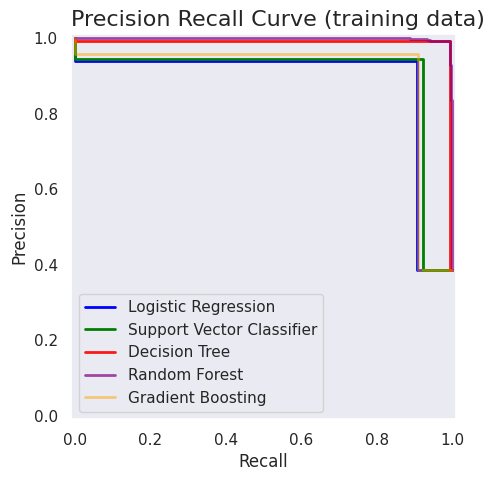

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
lr_prdisplay.plot(ax=ax, label='Logistic Regression', color='blue', linewidth=2)
svc_prdisplay.plot(ax=ax, label='Support Vector Classifier', color='green', linewidth=2)
tree_prdisplay.plot(ax=ax, label='Decision Tree', color='red', linewidth=2, alpha=.9)
rf_prdisplay.plot(ax=ax, label='Random Forest', color='purple', linewidth=2, alpha=.7)
xg_prdisplay.plot(ax=ax, label='Gradient Boosting', color='orange', linewidth=2, alpha=.5)
plt.title('Precision Recall Curve (training data)', size=16, loc='left')
plt.show()

In [ ]:
lr_params = [
              {'C': uniform(loc=0, scale=4),
              'penalty': ['l1','l2'],
              'solver': ['liblinear','saga']}
              ]

lr_randomcv = RandomizedSearchCV(lr, lr_params, cv=skfold,
                                 scoring='f1',
                                 return_train_score = True,
                                 random_state = 10,
                                 n_iter=100)

lr_randomcv.fit(X_train_pp, y_train)

print("---------------- Logistic Regression ---------------")
print("Best Parameters: ", lr_randomcv.best_params_)
print("Best Score: ", lr_randomcv.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/

---------------- Logistic Regression ---------------
Best Parameters:  {'C': 3.688931147614185, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.9211896009328526


In [ ]:
rf_params = [{
              'n_estimators': np.arange(50,500,50),
              'criterion': ['gini','entropy','logloss'],
              'max_depth': np.arange(2,14,2),
              'max_features': ['sqrt','log2',None, 0.5],
              }]

rf_randomcv = RandomizedSearchCV(rf, rf_params, cv=skfold,
                                 scoring='f1',
                                 return_train_score = True,
                                 random_state = 10,
                                 n_iter=100)

rf_randomcv.fit(X_train_pp, y_train)

print("----------------- Random Forest ----------------")
print("Best Parameters: ", rf_randomcv.best_params_)
print("Best Score: ", rf_randomcv.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


135 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

----------------- Random Forest ----------------
Best Parameters:  {'n_estimators': 400, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best Score:  0.9311933458302782


In [ ]:
xg_params = [{
              'n_estimators': np.arange(50,500,50),
              'loss': ['exponential','log_loss'],
              'max_depth': np.arange(2,14,2),
              'criterion': ['friedman_mse', 'squared_error'],
              'learning_rate': uniform(loc=0,scale=.5),
              'max_features': ['sqrt', 'log2', None, 0.5]
              }]

xg_randomcv = RandomizedSearchCV(xg, xg_params, cv=skfold,
                                 scoring='f1',
                                 return_train_score = True,
                                 random_state = 10,
                                 n_iter=50)

xg_randomcv.fit(X_train_pp, y_train)

print("--------------- Gradient Boosting --------------")
print("Best Parameters: ", xg_randomcv.best_params_)
print("Best Score: ", xg_randomcv.best_score_)

In [ ]:
X_test = test.drop('Converted',axis=1)
y_test = test.loc[:,'Converted']

# Let's take a look of the first row
X_test.to_numpy()[:1]

In [ ]:
# apply all the preprocessing steps to the test dataset
X_test_pp = pipe.transform(X_test)
X_test_pp.toarray()[:1]

In [ ]:
rf_rcv_pred = rf_randomcv.predict(X_test_pp)
print("Precision:", precision_score(y_test,rf_rcv_pred))
print("Recall:", recall_score(y_test,rf_rcv_pred))
print("F1 score:", f1_score(y_test,rf_rcv_pred))
print("ROC - AUC score:", roc_auc_score(y_test,rf_rcv_pred))

In [ ]:
rf_pred_test = rf.predict(X_test_pp)
print("Precision:", precision_score(y_test,rf_pred_test))
print("Recall:", recall_score(y_test,rf_pred_test))
print("F1 score:", f1_score(y_test,rf_pred_test))
print("ROC - AUC score:", roc_auc_score(y_test,rf_pred_test))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest tunned
cm1 = confusion_matrix(y_test, rf_rcv_pred)
sns.heatmap(cm1, annot=True, fmt = 'd', cmap='Greens', ax = ax[0], cbar=False)
ax[0].xaxis.set_ticklabels(['Not converted', 'Converted'])
ax[0].yaxis.set_ticklabels(['Not converted', 'Converted'])
ax[0].set_title('RF with hyperparameters tuning', loc='left')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Random Forest without tuning
cm2 = confusion_matrix(y_test, rf_pred_test)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax[1], cbar=False)
ax[1].xaxis.set_ticklabels(['Not converted', 'Converted'])
ax[1].yaxis.set_ticklabels(['Not converted', 'Converted'])
ax[1].set_title('RF without hyperparameters tuning', loc='left')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
lead_scoring = rf_randomcv.predict_proba(X_test_pp)[:,1]
lead_prediction = rf_rcv_pred
results = np.round(np.c_[lead_prediction,lead_scoring],2)

# Let's take a look of the first 10 rows
results[:10]